In [10]:
import warnings
warnings.filterwarnings("ignore")

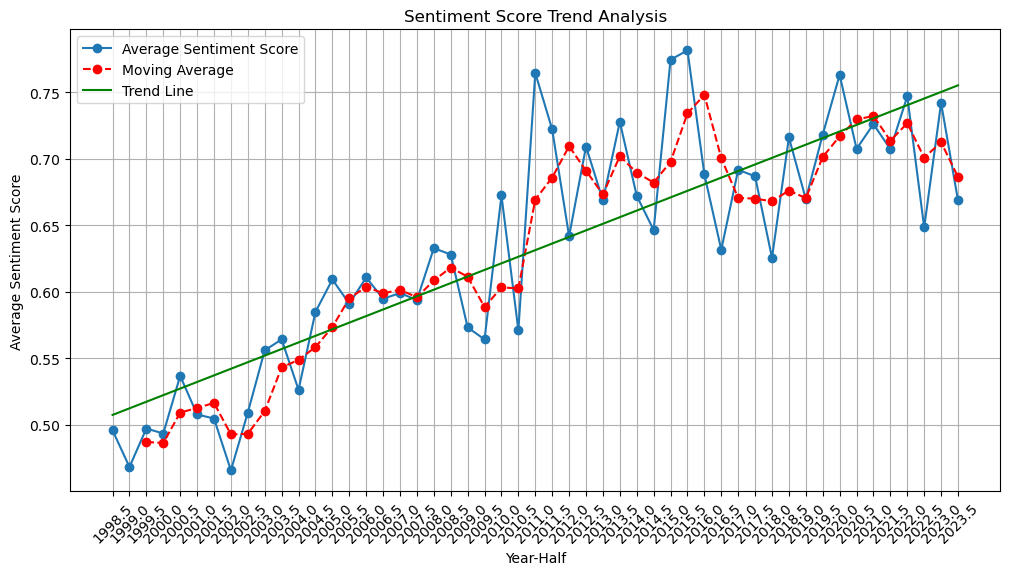

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

#change working directory
reviews_df = pd.read_csv('../data/Sentiment_Score.csv')

reviews_df['Date'] = pd.to_datetime(reviews_df['Date'])

reviews_df['Year-Half_Numeric'] = reviews_df['Date'].apply(lambda x: x.year + (0.5 if x.month > 6 else 0))

score_by_time = reviews_df.groupby('Year-Half_Numeric')['Sentiment_Score'].mean().reset_index()

score_by_time['Moving_Avg'] = score_by_time['Sentiment_Score'].rolling(window=3).mean()

X = score_by_time['Year-Half_Numeric'].values.reshape(-1, 1)
y = score_by_time['Sentiment_Score'].values

model = LinearRegression().fit(X, y)
score_by_time['Trend'] = model.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(score_by_time['Year-Half_Numeric'], score_by_time['Sentiment_Score'], marker='o', label='Average Sentiment Score')
plt.plot(score_by_time['Year-Half_Numeric'], score_by_time['Moving_Avg'], marker='o', linestyle='--', color='red', label='Moving Average')
plt.plot(score_by_time['Year-Half_Numeric'], score_by_time['Trend'], linestyle='-', color='green', label='Trend Line')

plt.xticks(score_by_time['Year-Half_Numeric'], rotation=45)
plt.xlabel('Year-Half')
plt.ylabel('Average Sentiment Score')
plt.title('Sentiment Score Trend Analysis')
plt.legend()
plt.grid(True)
plt.show()


Correlation Matrix:
                              Transformed_Sentiment_Score    Rating
Transformed_Sentiment_Score                     1.000000  0.757396
Rating                                          0.757396  1.000000

Spearman Correlation Coefficient:  0.7055647694706387
Spearman P-value:  2.1264551409578257e-181

Descriptive Statistics:
        Transformed_Sentiment_Score       Rating
count                  1200.000000  1200.000000
mean                      6.383814     7.029167
std                       2.624475     3.484983
min                       1.002166     1.000000
25%                       4.233460     4.000000
50%                       6.760628     9.000000
75%                       8.589163    10.000000
max                       9.998989    10.000000


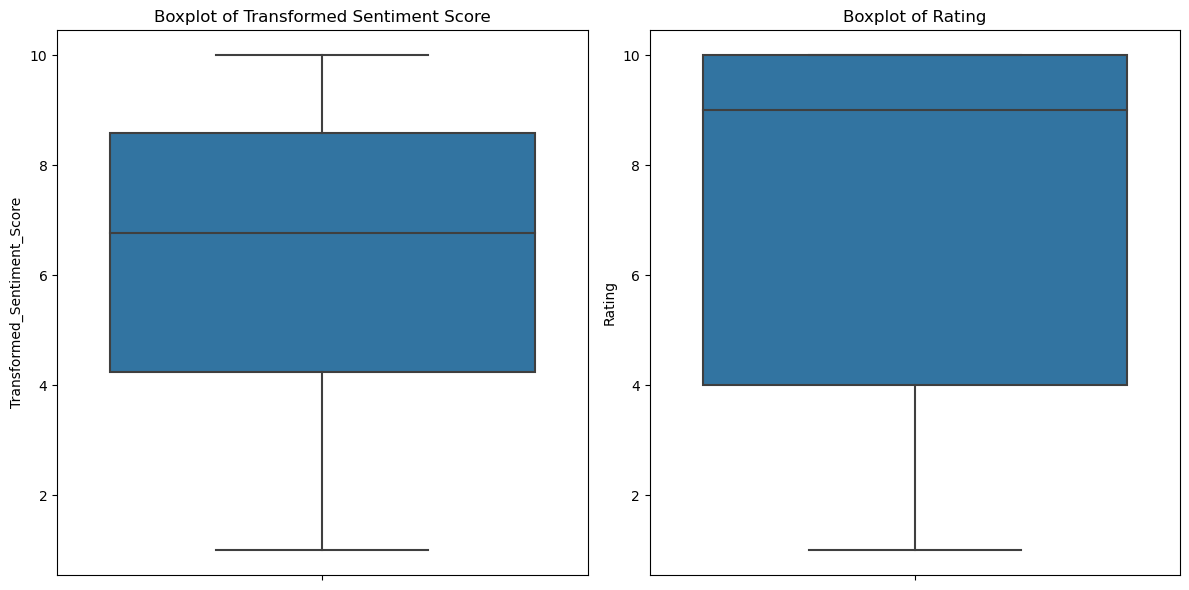

In [8]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

imdb_reviews_path = '../data/imdb_reviews_rating.csv'

imdb_reviews = pd.read_csv(imdb_reviews_path)

merged_df = pd.merge(reviews_df, imdb_reviews[['Author', 'Rating']], on='Author', how='left')

merged_df = merged_df[merged_df['Rating'] != 'No Rating']
merged_df.dropna(subset=['Rating'], inplace=True)

merged_df['Rating'] = merged_df['Rating'].str.split('/').str[0]
merged_df['Rating'] = pd.to_numeric(merged_df['Rating'], errors='coerce')

merged_df['Transformed_Sentiment_Score'] = (merged_df['Sentiment_Score'] * 9)+1

transformed_correlation = merged_df[['Transformed_Sentiment_Score', 'Rating']].corr()

spearman_corr_transformed, spearman_p_value_transformed = stats.spearmanr(merged_df['Transformed_Sentiment_Score'], merged_df['Rating'], nan_policy='omit')

print("Correlation Matrix:\n", transformed_correlation)
print("\nSpearman Correlation Coefficient: ", spearman_corr_transformed)
print("Spearman P-value: ", spearman_p_value_transformed)

print("\nDescriptive Statistics:\n", merged_df[['Transformed_Sentiment_Score', 'Rating']].describe())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=merged_df, y='Transformed_Sentiment_Score')
plt.title('Boxplot of Transformed Sentiment Score')

plt.subplot(1, 2, 2)
sns.boxplot(data=merged_df, y='Rating')
plt.title('Boxplot of Rating')

plt.tight_layout()
plt.show()

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.tsa.stattools import arma_order_select_ic

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Assuming 'Sentiment_Score' is your target variable
results_aic = []
for order in pdq:
    try:
        model = SARIMAX(score_by_time['Sentiment_Score'], order=order)
        results = model.fit(disp=False)
        results_aic.append((order, results.aic))
    except:
        continue

# Find the order with the lowest AIC
best_order = min(results_aic, key=lambda x: x[1])[0]
print(f"Best ARIMA Order: {best_order}")

Best ARIMA Order: (0, 1, 1)


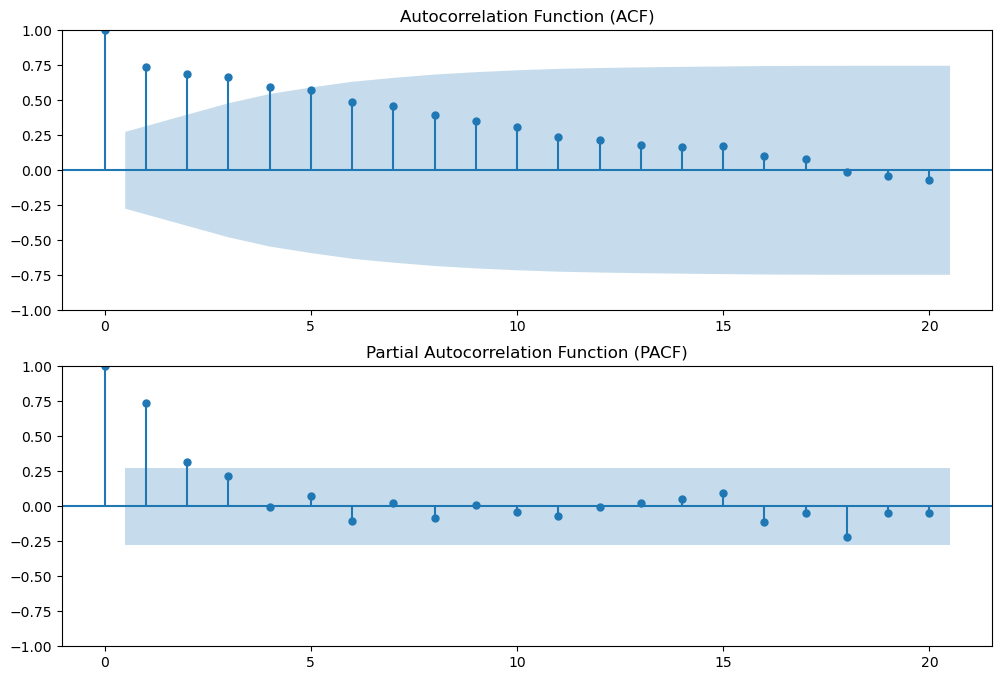

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

reviews_df['Year-Half_Numeric'] = reviews_df['Date'].apply(lambda x: x.year + (0.5 if x.month > 6 else 0))

# Group by 'Year-Half_Numeric' and calculate the mean sentiment score
score_by_time = reviews_df.groupby('Year-Half_Numeric')['Sentiment_Score'].mean().reset_index()

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(score_by_time['Sentiment_Score'], ax=ax1, lags=20)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(score_by_time['Sentiment_Score'], ax=ax2, lags=20)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

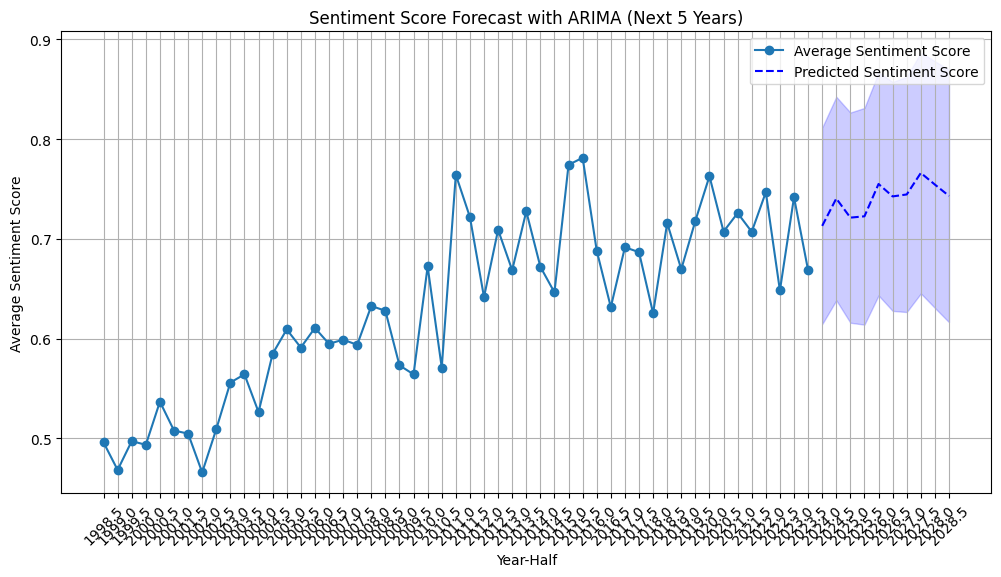

In [ ]:
# Assuming 'Date' column is in datetime format
reviews_df['Year-Half_Numeric'] = reviews_df['Date'].apply(lambda x: x.year + (0.5 if x.month > 6 else 0))

# Group by 'Year-Half_Numeric' and calculate the mean sentiment score
score_by_time = reviews_df.groupby('Year-Half_Numeric')['Sentiment_Score'].mean().reset_index()

# Fit ARIMA model
model = SARIMAX(score_by_time['Sentiment_Score'], order=(0, 1, 1), seasonal_order=(1, 1, 1, 6))  # Example order, you may need to tune these parameters
results = model.fit(disp=False)

# Predict sentiment scores for the next 5 years (10 half-years)
future_years = np.arange(score_by_time['Year-Half_Numeric'].max() + 0.5, score_by_time['Year-Half_Numeric'].max() + 5.5, 0.5)
future_predictions = results.get_forecast(steps=len(future_years))
predicted_mean = future_predictions.predicted_mean
confidence_interval = future_predictions.conf_int()

# Add future predictions to the DataFrame
future_df = pd.DataFrame({'Year-Half_Numeric': future_years, 'Predicted_Sentiment_Score': predicted_mean.values})
score_by_time = pd.concat([score_by_time, future_df], ignore_index=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(score_by_time['Year-Half_Numeric'], score_by_time['Sentiment_Score'], marker='o', label='Average Sentiment Score')
plt.plot(score_by_time['Year-Half_Numeric'], score_by_time['Predicted_Sentiment_Score'], linestyle='--', color='blue', label='Predicted Sentiment Score')

# Plot confidence interval (optional)
plt.fill_between(future_years, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='blue', alpha=0.2)

plt.xticks(score_by_time['Year-Half_Numeric'], rotation=45)
plt.xlabel('Year-Half')
plt.ylabel('Average Sentiment Score')
plt.title('Sentiment Score Forecast with ARIMA (Next 5 Years)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Assuming 'Date' column is in datetime format
reviews_df['Year-Half_Numeric'] = reviews_df['Date'].apply(lambda x: x.year + (0.5 if x.month > 6 else 0))

# Group by 'Year-Half_Numeric' and calculate the mean sentiment score
score_by_time = reviews_df.groupby('Year-Half_Numeric')['Sentiment_Score'].mean().reset_index()

# Fit ARIMA model
model = SARIMAX(score_by_time['Sentiment_Score'], order=(0, 1, 1), seasonal_order=(1, 1, 1, 6))  # Example order, you may need to tune these parameters
results = model.fit(disp=False)

# Predict sentiment scores for the next 5 years (10 half-years)
future_years = np.arange(score_by_time['Year-Half_Numeric'].max() + 0.5, score_by_time['Year-Half_Numeric'].max() + 5.5, 0.5)
future_predictions = results.get_forecast(steps=len(future_years))
predicted_mean = future_predictions.predicted_mean
confidence_interval = future_predictions.conf_int()

# Create a DataFrame with predictions and confidence interval
prediction_df = pd.DataFrame({
    'Year': future_years,
    'Predicted_Sentiment_Score': predicted_mean.values,
    'Lower_Bound': confidence_interval.iloc[:, 0].values,
    'Upper_Bound': confidence_interval.iloc[:, 1].values
})
print(prediction_df)

     Year  Predicted_Sentiment_Score  Lower_Bound  Upper_Bound
0  2024.0                   0.713079     0.614529     0.811629
1  2024.5                   0.740517     0.638499     0.842535
2  2025.0                   0.721350     0.615977     0.826722
3  2025.5                   0.722681     0.614068     0.831295
4  2026.0                   0.755096     0.643359     0.866833
5  2026.5                   0.742622     0.627846     0.857398
6  2027.0                   0.744595     0.626707     0.862483
7  2027.5                   0.766159     0.645348     0.886970
8  2028.0                   0.754468     0.630803     0.878133
9  2028.5                   0.743119     0.616508     0.869730
